In [11]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class RemoveFirstFrame(BaseEstimator, TransformerMixin):
    def __init__(self, frame):
        self.frame = frame
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.query(f"Step % {frame} != 1")
def choose_top_rw(data,n=5):
    return data.assign(chosen=pd.DataFrame.rank(data.Rw, method='first')<=n)
def choose_top_vtotal(data,n=5):
    return data.assign(chosen=pd.DataFrame.rank(data.VTotal, method='first')<=n)
def choose_top(data,col="Qw", n=5, ascending=False):
    return data.assign(chosen=pd.DataFrame.rank(data[col], ascending=ascending, method='first')<=n)

In [64]:
raw_test_data = pd.read_csv("/Users/weilu/Research/data/test_data/complete_data_mar27.csv", index_col=0)

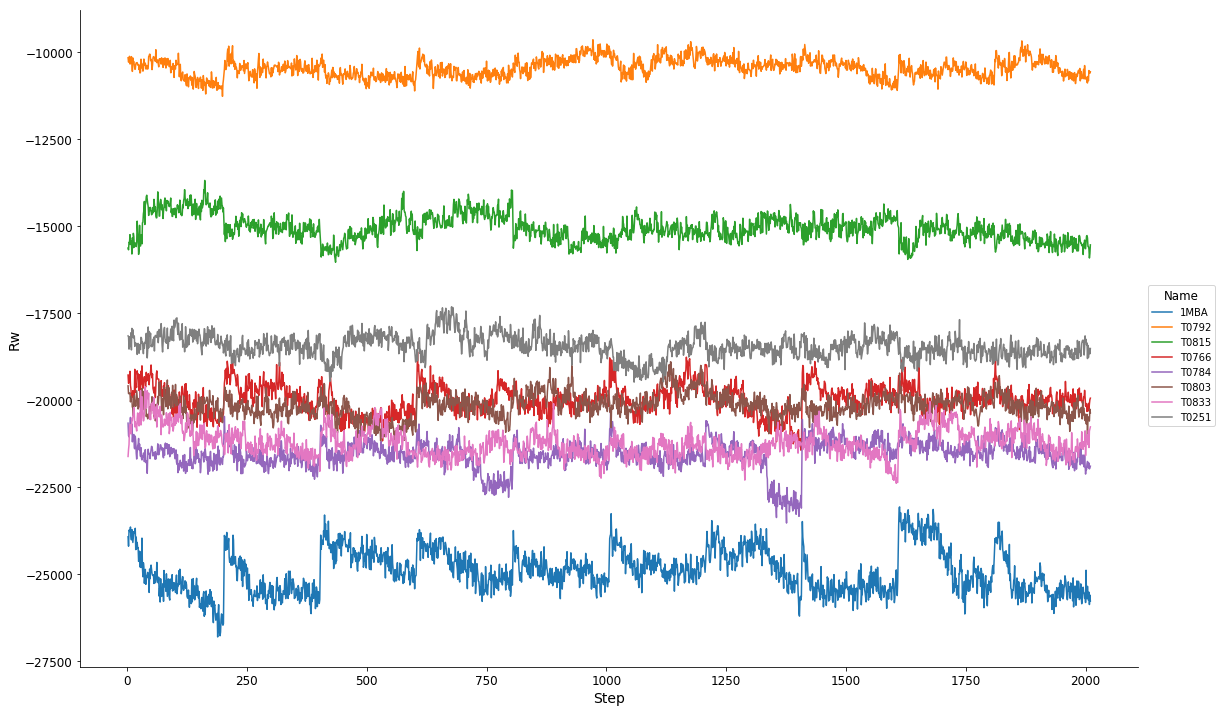

In [66]:
import seaborn
fg = seaborn.FacetGrid(data=raw_test_data, hue='Name',  aspect=1.61, size=10)
fg.map(plt.plot, 'Step', 'Rw').add_legend()

In [65]:
raw_test_data

,Burial,Chain,Chi,DSSP,Frag_Mem,GDT,Helix,Name,P_AP,QGO,Qw,Rama,Rmsd,Rw,Step,VTotal,VwithoutGo,Water,isGood
0,-125.527566,198.348772,50.712241,-0.000001,-270.954728,64.0425,-31.903978,1MBA,-3.510140,20.437024,0.612991,-608.466001,2.83047,-23936.084181,2,-815.660991,-836.098015,-44.796614,False
1,-127.621760,202.520695,48.958767,-0.000000,-264.937301,60.4475,-44.122252,1MBA,-4.427336,22.635465,0.608468,-598.442065,3.11564,-24206.526672,3,-810.210414,-832.845879,-44.774626,False
2,-126.897613,201.171981,45.683736,-0.000016,-285.284868,59.9325,-44.705003,1MBA,-2.790484,32.291579,0.563456,-601.607208,3.34374,-23746.829469,4,-831.611615,-863.903194,-49.473719,False
3,-129.227459,211.599927,43.332617,-0.000000,-284.484618,60.1050,-44.940302,1MBA,-3.275868,31.026159,0.568731,-608.560594,3.31919,-23770.585063,5,-835.827804,-866.853963,-51.297665,False
4,-125.640142,210.098567,52.818004,-0.000000,-301.367085,57.8775,-47.194714,1MBA,-4.095876,34.395024,0.552951,-616.317106,3.65728,-23788.221633,6,-845.665112,-880.060136,-48.361783,False
5,-126.596875,178.674935,37.575281,-0.000000,-313.910386,60.1050,-49.238866,1MBA,-3.546136,32.651915,0.556017,-621.844923,3.31292,-23655.850471,7,-912.270330,-944.922245,-46.035274,False
6,-126.363437,170.111959,39.655774,-0.000002,-274.534180,61.3025,-50.380709,1MBA,-2.877070,28.954400,0.584000,-632.719444,3.15679,-23915.867387,8,-896.728930,-925.683330,-48.576221,False
7,-126.587872,183.226188,42.971890,-0.000220,-318.007849,63.7000,-49.805937,1MBA,-3.325704,26.661054,0.603713,-616.551470,3.01623,-24025.154290,9,-912.484393,-939.145447,-51.064472,False
8,-127.045921,198.521740,43.660693,-0.000174,-281.688080,61.3000,-38.269670,1MBA,-3.149545,27.835810,0.576972,-605.484179,3.13825,-23730.122955,10,-833.630852,-861.466662,-48.011525,False
9,-127.821988,167.915369,38.463602,-0.000064,-306.039620,62.6725,-39.167075,1MBA,-4.185415,35.135000,0.575112,-617.809782,3.16134,-23934.967672,11,-900.801360,-935.936360,-47.291386,False


In [14]:
raw_test_data["Name"].unique()

array(['1MBA', 'T0792', 'T0815', 'T0766', 'T0784', 'T0803', 'T0833',
       'T0251'], dtype=object)

In [35]:
FEATURES = ['Rw',
#      'VTotal',
#      'QGO',
#      'VwithoutGo',
     'Burial',
     'Water',
     'Rama',
#      'DSSP',
#      'P_AP',
     'Helix',
#      'Frag_Mem'
               ]
n = 5
def my_transform(data, label, degree, FEATURES=FEATURES):

    # LABEL = "Qw"
    LABEL = label
    PolynomialDegree = degree

    num_attribs = FEATURES
    cat_attribs = [LABEL]
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    return full_pipeline.fit_transform(data)

def my_transform_predict(data, degree, FEATURES=FEATURES):

    # LABEL = "Qw"
    PolynomialDegree = degree

    num_attribs = FEATURES
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    return num_pipeline.fit_transform(data)

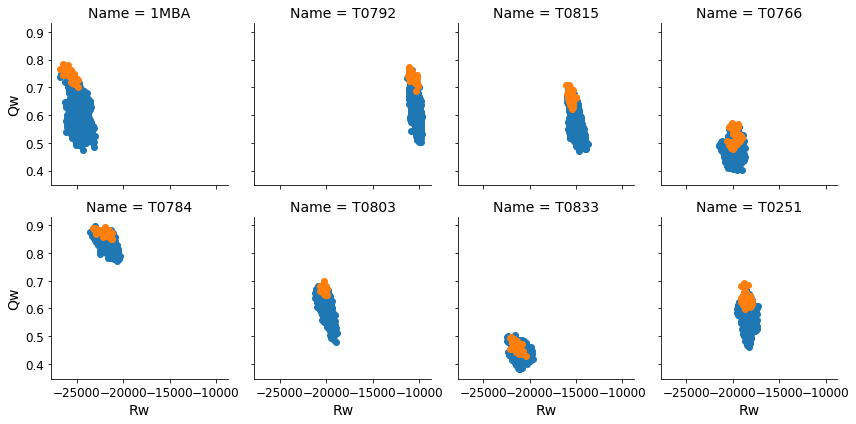

In [36]:
g = sns.FacetGrid(raw_test_data, col="Name", hue="isGood", col_wrap=4)
g = g.map(plt.scatter, "Rw", "Qw")

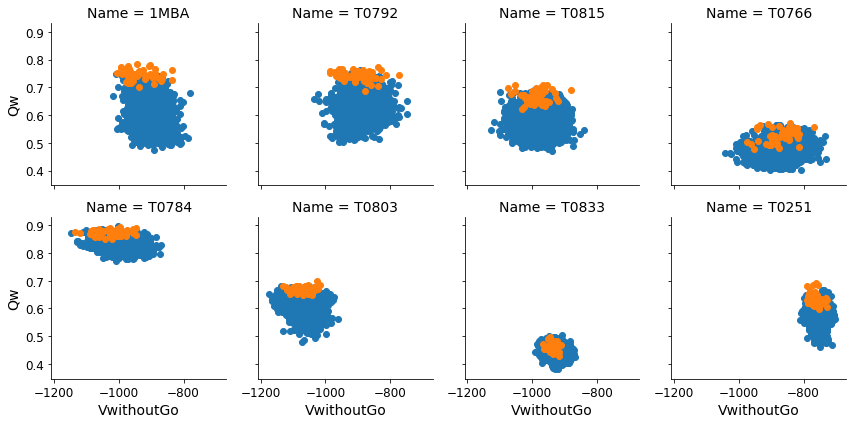

In [37]:
g = sns.FacetGrid(raw_test_data, col="Name", hue="isGood", col_wrap=4)
g = g.map(plt.scatter, "VwithoutGo", "Qw")

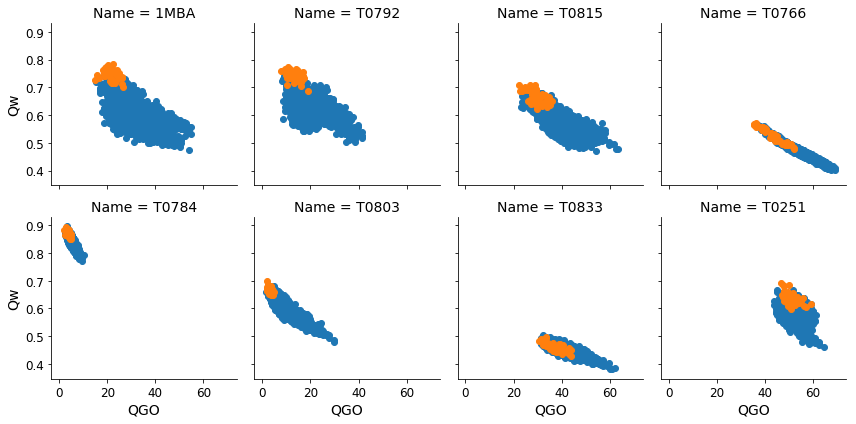

In [38]:
g = sns.FacetGrid(raw_test_data, col="Name", hue="isGood", col_wrap=4)
g = g.map(plt.scatter, "QGO", "Qw")

In [39]:
raw_data_T0784 = raw_test_data.groupby("Name").get_group("T0784")
# raw_data_T0792 = raw_test_data.groupby("Name").get_group("T0792")
# raw_data = pd.concat([raw_data_T0784, raw_data_T0792])
# raw_data = raw_data_T0792
# raw_data = raw_test_data.groupby("Name").get_group("1mba")
raw_data = raw_data_T0784

In [40]:
# FEATURES = ["Rw", "VTotal", "QGO"]
# FEATURES = ["Rw", "VTotal", "QGO", "Burial", "Frag_Mem", "Water"]
# FEATURES = list(raw_test_data.columns[2:-3])
def train_and_test(raw_data, label="Qw", degree=1, p=0.1):
    # my_full_pipeline = Pipeline([
    # #         ('removeFirstFrame', RemoveFirstFrame(frame)),
    #         ('featureSelection', full_pipeline)
    # ])

    from sklearn.model_selection import StratifiedShuffleSplit

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=142)
    for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
        strat_train_set = raw_data.iloc[train_index]
        strat_test_set = raw_data.iloc[test_index]
    # strat_test_set[LABEL].value_counts() / len(strat_test_set)
    X_train = my_transform(strat_train_set, label, degree)
    X_test = my_transform(strat_test_set, label, degree)
    train_y = X_train[:,-1]
    train_set = X_train[:,:-1]
    test_y = X_test[:,-1]
    test_set = X_test[:,:-1]
    return (train_set, train_y, test_set, test_y)

In [54]:
label = "isGood"
degree = 1
p = 0.1
train_set, train_y, test_set, test_y = train_and_test(raw_data, label=label, degree=degree)
log_clf = LogisticRegression(random_state=140, penalty='l2')

# log_clf = LogisticRegression(random_state=14, class_weight={0:p, 1:(1-p)}, penalty='l1')
log_clf.fit(train_set, train_y)
y_pred = log_clf.predict(train_set)
# n = 100
prediction_list = []
for name, data in raw_test_data.groupby("Name"):
    print(name)
#     X = full_pipeline.fit_transform(data)
    X = my_transform(data, label, degree)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    one = data.assign(prediction=test)
    prediction_list.append(one)
#     prediction_list.append(pd.Series(test))
t = pd.concat(prediction_list)
# t = raw_test_data.assign(prediction=prediction.values)
best_by_prediction = t.groupby("Name").apply(choose_top, n=5, col="prediction").query("chosen==True")

1MBA
T0251
T0766
T0784
T0792
T0803
T0815
T0833


In [55]:
a = best_by_prediction.reset_index(drop=True)[["Name", "Qw", "GDT", "Rmsd", "prediction", "Step"]].groupby("Name").apply(lambda x: x.sort_values("prediction", ascending=False))

In [56]:
# best_by_prediction.to_csv("/Users/weilu/Research/davinci/structure_selector_apr09/selected.csv")
# a = pd.read_csv("/Users/weilu/Research/davinci/structure_selector_apr09/selected.csv")
# for i, row in a.iterrows():
#     print(i, row["Name"], row["Step"])

In [59]:
print(*(zip(FEATURES, log_clf.coef_[0])))

('Rw', -0.49825533989977439) ('Burial', 0.11535990415932022) ('Water', -0.096733273202118164) ('Rama', -0.16924406917860341) ('Helix', -0.16299557498004696)


In [60]:
n = 5
chosen_by_rw = raw_test_data.groupby("Name").apply(choose_top_rw, n)
chosen_by_vtotal = raw_test_data.groupby("Name").apply(choose_top_vtotal, n)
chosen_by_qgo = raw_test_data.groupby("Name").apply(choose_top, n=n, col="QGO", ascending=True)
top_rw = chosen_by_rw.query("chosen==True")
top_vtotal = chosen_by_vtotal.query("chosen==True")
top_qgo = chosen_by_qgo.query("chosen==True")

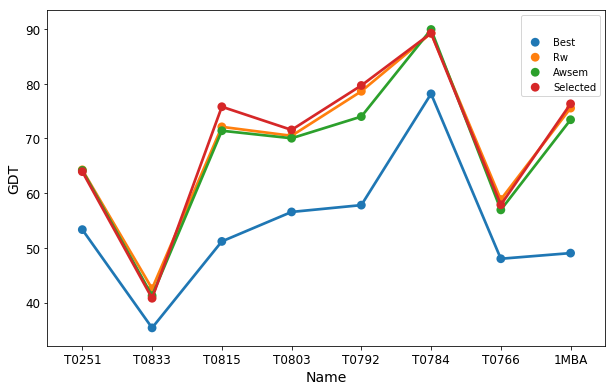

In [63]:
# T0784
label = "GDT"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label, ascending=True).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
# plt.savefig("/Users/weilu/Desktop/fig6_GDT.png", dpi=300)
# plt.ylim([0.4,1])
final_gdt = final3

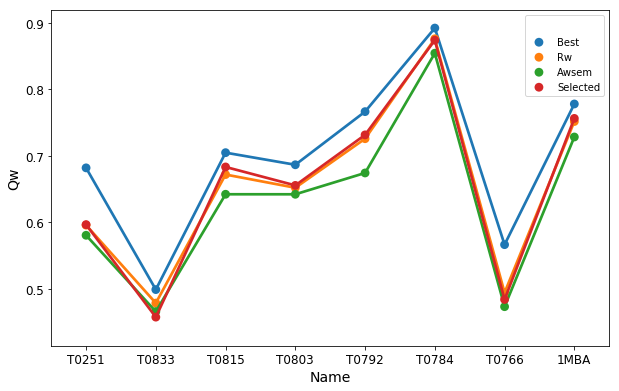

In [62]:
# T0784
label = "Qw"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
plt.savefig("/Users/weilu/Desktop/fig6_Qw.png", dpi=300)
# plt.ylim([0.4,1])
final_Qw = final3

In [16]:
print(*(zip(FEATURES, log_clf.coef_[0])))

('Rw', -0.19232275270600122) ('QGO', -1.6223111058603839) ('VwithoutGo', -0.28966535406693028)


In [25]:
n = 5
chosen_by_rw = raw_test_data.groupby("Name").apply(choose_top_rw, n)
chosen_by_vtotal = raw_test_data.groupby("Name").apply(choose_top_vtotal, n)
chosen_by_qgo = raw_test_data.groupby("Name").apply(choose_top, n=n, col="QGO", ascending=True)
top_rw = chosen_by_rw.query("chosen==True")
top_vtotal = chosen_by_vtotal.query("chosen==True")
top_qgo = chosen_by_qgo.query("chosen==True")

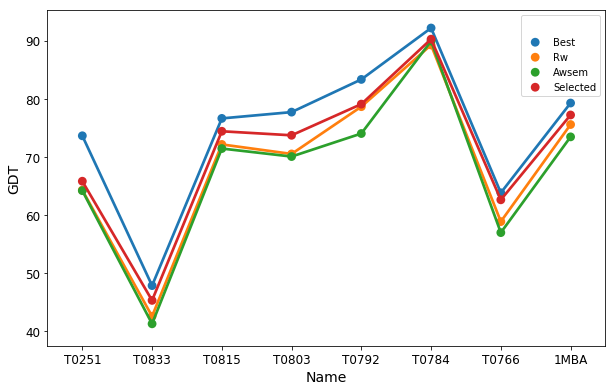

In [15]:
# T0784
label = "GDT"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
# plt.savefig("/Users/weilu/Desktop/fig6_GDT.png", dpi=300)
# plt.ylim([0.4,1])
final_gdt = final3

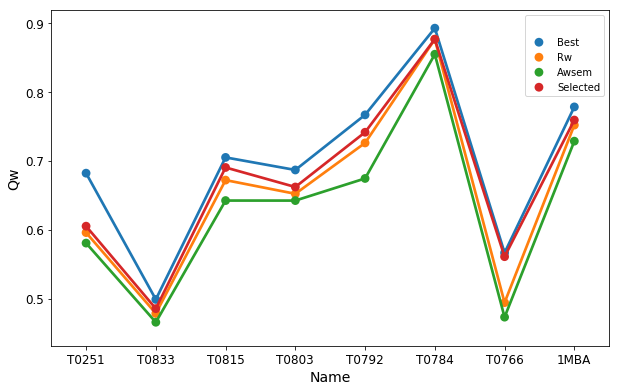

In [23]:
# T0784
label = "Qw"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
plt.savefig("/Users/weilu/Desktop/fig6_Qw.png", dpi=300)
# plt.ylim([0.4,1])
final_Qw = final3

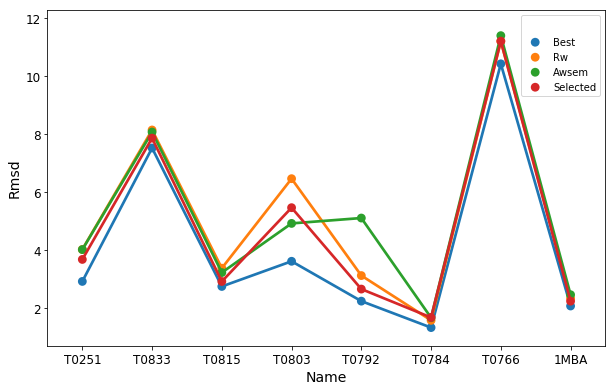

In [24]:
# T0784
label = "Rmsd"
best = raw_test_data.groupby("Name").apply(choose_top, n=n, col=label, ascending=True).query("chosen==True")
a2 = best.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Best"})
b2 = top_rw.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Rw"})
c2 = top_vtotal.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"Awsem"})
d2 = best_by_prediction.reset_index(drop=True)[["Name", label]].rename(index=str,columns={label:"Selected"})
e2 = top_qgo.reset_index(drop=True)[[label, "Name"]].rename(index=str,columns={label:"QGo"})
# final2 = a2.merge(b2, on="Name").merge(c2, on="Name").merge(d2, on="Name").melt(id_vars="Name")
# final2 = pd.concat([a2, e2["QGo"], b2["Rw"], c2["Awsem"], d2["prediction"]], axis=1).melt(id_vars="Name")
final3 = pd.concat([a2, b2["Rw"], c2["Awsem"], d2["Selected"]], axis=1).melt(id_vars="Name", value_name=label, var_name=" ")
# sns.pointplot("Name","value", data=final2, hue="variable", hue_order=["prediction", "Awsem", "Rw", "best"])
# sns.stripplot("value", "Name", data=final2, hue="variable")
order = ["T0251", "T0833", "T0815", "T0803", "T0792", "T0784", "T0766", "1MBA"]
sns.pointplot("Name", label, data=final3, hue=" ", errwidth=0, order=order)
plt.savefig("/Users/weilu/Desktop/fig6_Rmsd.png", dpi=300)
# plt.ylim([0.4,1])
final_Rmsd = final3

In [32]:
final = pd.concat([final_gdt, final_Qw["Qw"], final_Rmsd["Rmsd"]], axis=1)

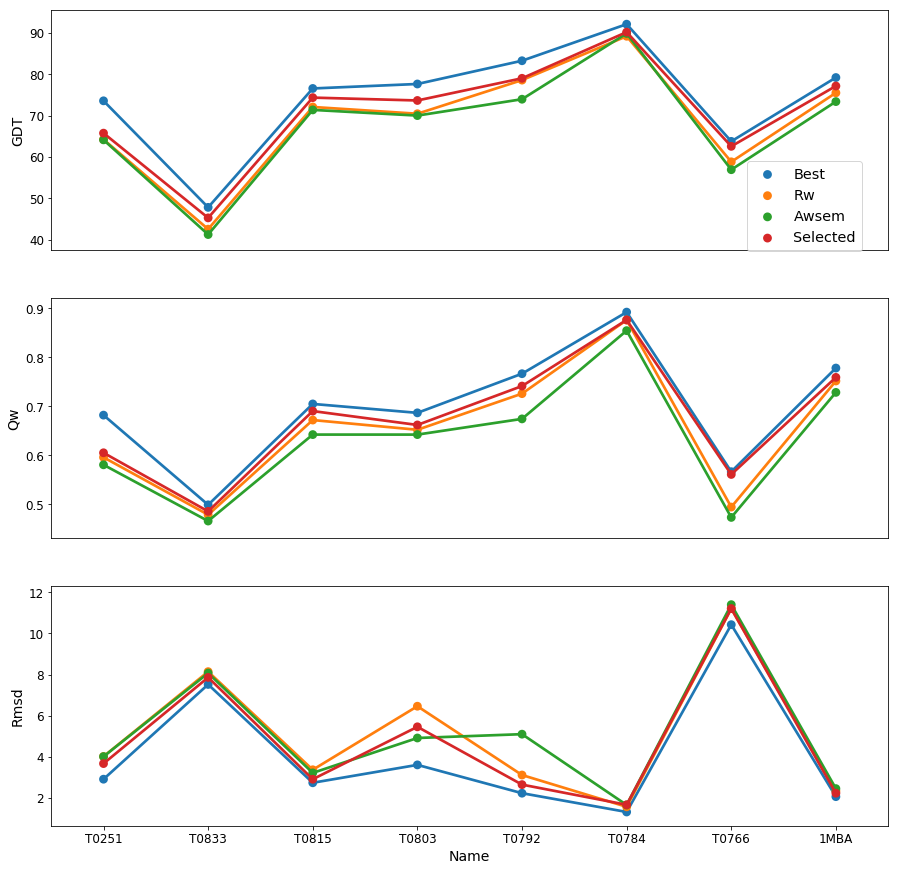

In [64]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15,15))
sns.pointplot("Name", "GDT", data=final, hue=" ", errwidth=0, order=order, ax=ax1)
ax1.legend_.remove()
ax1.get_xaxis().set_visible(False)
sns.pointplot("Name", "Qw", data=final, hue=" ", errwidth=0, order=order, ax=ax2)
ax2.legend_.remove()
ax2.get_xaxis().set_visible(False)
sns.pointplot("Name", "Rmsd", data=final, hue=" ", errwidth=0, order=order, ax=ax3)
plt.legend(loc=9, bbox_to_anchor=(0.9, 2.8), ncol=1, fontsize='x-large')
plt.savefig("/Users/weilu/Desktop/fig6.png", dpi=300)